In [ ]:
!pip install earthengine-api geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.7 MB/s eta 0:00:00


In [ ]:
!earthengine authenticate

E0000 00:00:1749824463.986216    6397 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749824463.991875    6397 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W0613 14:21:08.113012 136619168378880 _default.py:711] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20h

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 96.4 MB/s eta 0:00:00


In [ ]:
# prompt: mount google drive navigate to dir GEE_Exports

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/My Drive/GEE_Exports')


Mounted at /content/drive


In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 100.5 MB/s eta 0:00:00


In [ ]:
import geemap
import geopandas as gpd
import folium
from shapely.geometry import shape
import rasterio

In [ ]:
import ee, geemap
ee.Initialize()

# ROI
dakar_roi = ee.Geometry.Rectangle([-17.9, 14.5, -17, 15.1])

nairobi_county_roi = ee.Geometry.Rectangle([36.55, -1.50, 3.10, -1.10])


# Dataset
dataset = ee.ImageCollection("GOOGLE/Research/open-buildings-temporal/v1")

# Visualization parameters
vis_params_2016 = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'red'],  # 2016 in red
    'opacity': 0.5
}

vis_params_2023 = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'blue'],  # 2023 in blue
    'opacity': 0.5
}

# 2016
filtered_2016 = dataset.filterDate('2016-01-01', '2016-12-31')
mosaic_2016 = filtered_2016.mosaic()
clipped_2016 = mosaic_2016.clip(dakar_roi)
building_presence_2016 = clipped_2016.select('building_presence')

# 2023
filtered_2023 = dataset.filterDate('2023-01-01', '2023-12-31')
mosaic_2023 = filtered_2023.mosaic()
clipped_2023 = mosaic_2023.clip(dakar_roi)
building_presence_2023 = clipped_2023.select('building_presence')

# Display
Map = geemap.Map()
Map.centerObject(dakar_roi, 12)
Map.addLayer(building_presence_2016, vis_params_2016, 'Building Presence 2016 (Red)')
Map.addLayer(building_presence_2023, vis_params_2023, 'Building Presence 2023 (Blue)')
Map

Map(center=[14.80029807775127, -17.44999999999997], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
import ee, time

# Initialize Earth Engine
ee.Initialize()

# Define ROI
dakar_roi = ee.Geometry.Rectangle([-17.8, 14.5, -17.1, 15.1])

# Load dataset
dataset = ee.ImageCollection("GOOGLE/Research/open-buildings-temporal/v1")

#change export folder name here
def export_building_data(year, roi, folder='GEE_Exports'):
    # Filter and prepare image
    filtered = dataset.filterDate(f'{year}-01-01', f'{year}-12-31')
    mosaic = filtered.mosaic()
    clipped = mosaic.clip(roi)
    building_presence = clipped.select('building_presence')
    building_height = clipped.select('building_height')

    # Combine bands into one image with two bands
    combined_image = building_presence.addBands(building_height)

    # Define export task
    export_task = ee.batch.Export.image.toDrive(
        image=combined_image,
        description=f'Dakar_Building_Presence_Height_{year}',
        folder=folder,
        fileNamePrefix=f'dakar_building_presence_height_{year}',
        region=roi,
        scale=4,  # Native resolution
        crs='EPSG:4326',
        maxPixels=1e13
    )

    # Start export
    export_task.start()
    print(f"Export started for {year}. Waiting for completion...")

    # Monitor progress
    while export_task.active():
        print(f'Task status for {year}: {export_task.status()["state"]}')
        time.sleep(10)

    print(f"Export complete for {year}:", export_task.status())

# Export for 2016 and 2023
export_building_data(2016, dakar_roi)
export_building_data(2023, dakar_roi)

Export started for 2016. Waiting for completion...
Task status for 2016: READY
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016: RUNNING
Task status for 2016:

In [ ]:
import rasterio

# List of file paths
tif_paths = ["../raw/dakar_building_presence_height_2016.tif", "../raw/dakar_building_presence_height_2023.tif"]

for path in tif_paths:
    with rasterio.open(path) as src:
        print(f"File: {path}")
        print(f"Number of bands: {src.count}")
        # Rasterio doesn't provide band names directly since TIFF bands often have no names.
        # But if the file has tags with band descriptions, you can try this:
        for i in range(1, src.count + 1):
            desc = src.descriptions[i - 1]  # descriptions list indexed by band number - 1
            print(f"Band {i} description: {desc}")
        print()

File: shapefiles/Dakar_data/dakar_building_presence_height_2016.tif
Number of bands: 2
Band 1 description: building_presence
Band 2 description: building_height

File: shapefiles/Dakar_data/dakar_building_presence_height_2023.tif
Number of bands: 2
Band 1 description: building_presence
Band 2 description: building_height



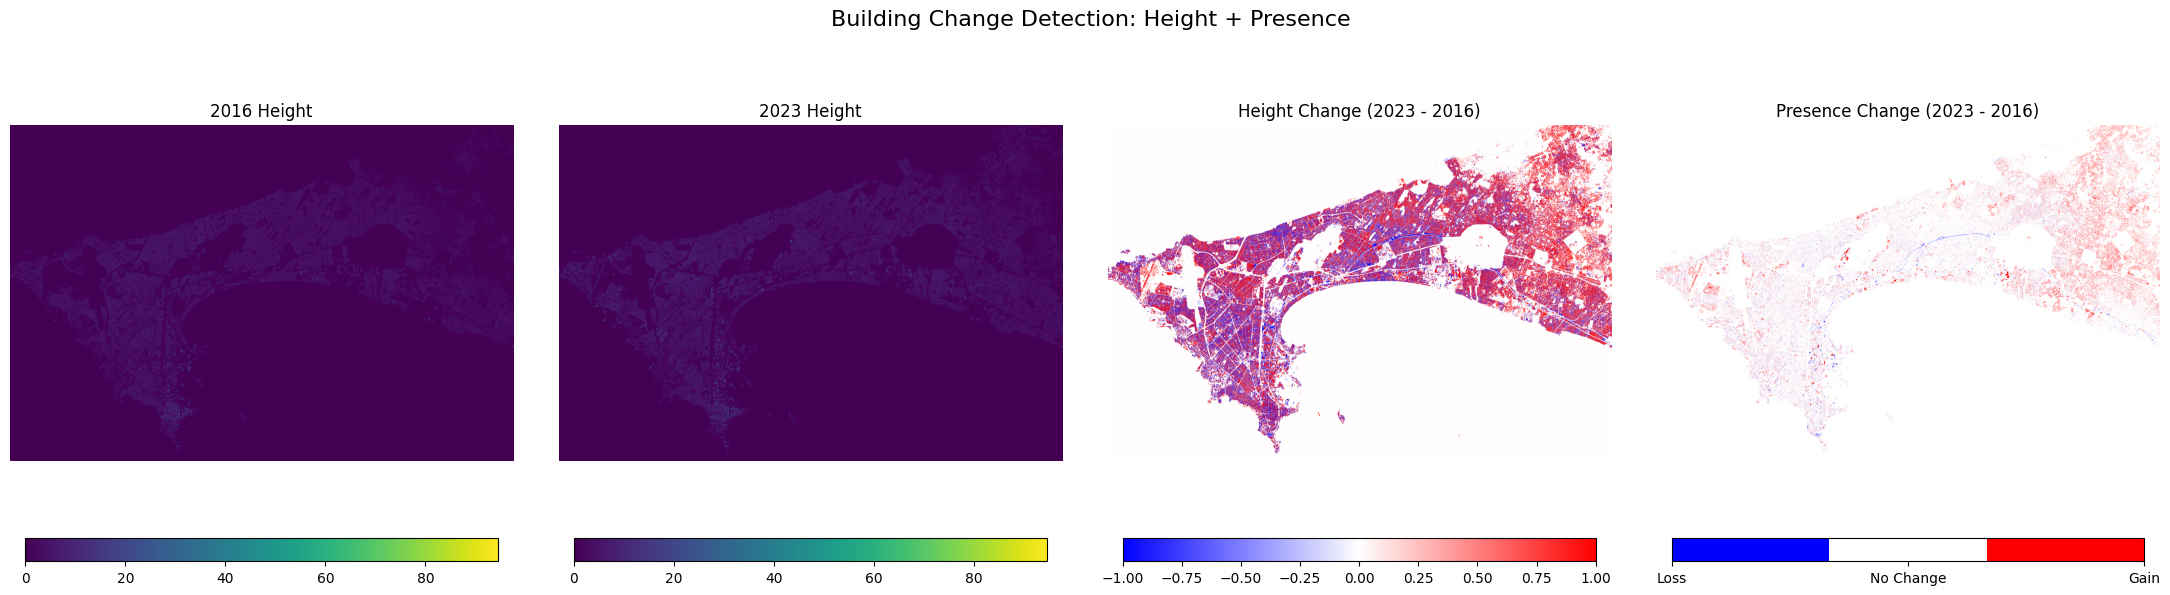


Binary presence stats:
2016 present: 3044406
2023 present: 3723638
Presence gains (0→1): 736473
Presence losses (1→0): 213674
Presence unchanged (|Δprob| ≤ 0.5): 36549853

Heights:
2016 min/max: 0.0 94.52344
2023 min/max: 0.0 89.27344
Height diff min/max: -57.828125 81.83594


In [ ]:
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np

# === File paths ===
tif_2016_path = "../raw/dakar_building_presence_height_2016.tif"
tif_2023_path = "../raw/dakar_building_presence_height_2023.tif"

# === Define window ===
window = Window(col_off=7700, row_off=7700, width=7500, height=5000)

# === Load 2016 raster window ===
with rasterio.open(tif_2016_path) as src_2016:
    presence_2016 = src_2016.read(1, window=window)
    height_2016 = src_2016.read(2, window=window)
    crs_2016 = src_2016.crs
    transform_2016 = src_2016.window_transform(window)

# === Load 2023 raster window ===
with rasterio.open(tif_2023_path) as src_2023:
    presence_2023 = src_2023.read(1, window=window)
    height_2023 = src_2023.read(2, window=window)
    crs_2023 = src_2023.crs
    transform_2023 = src_2023.window_transform(window)

# === Clean NaNs and compute difference ===
height_diff = height_2023 - height_2016
presence_prob_diff = presence_2023 - presence_2016

# Mask invalid values
nan_mask = np.isnan(presence_2016) | np.isnan(presence_2023)
height_diff[nan_mask] = np.nan
presence_prob_diff[nan_mask] = np.nan
height_2016[nan_mask] = np.nan
height_2023[nan_mask] = np.nan
presence_2016[nan_mask] = np.nan
presence_2023[nan_mask] = np.nan

# === Binary presence masks ===
threshold = 0.5
bin_presence_2016 = (presence_2016 >= threshold).astype(np.uint8)
bin_presence_2023 = (presence_2023 >= threshold).astype(np.uint8)

# === Presence change classification ===
diff_threshold = 0.5
presence_change = np.zeros_like(presence_prob_diff, dtype=np.int8)
presence_change[presence_prob_diff > diff_threshold] = 1    # Gain
presence_change[presence_prob_diff < -diff_threshold] = -1  # Loss

# === Visualization ===
fig, axs = plt.subplots(1, 4, figsize=(22, 6))

vmin = min(np.nanmin(height_2016), np.nanmin(height_2023))
vmax = max(np.nanmax(height_2016), np.nanmax(height_2023))

im0 = axs[0].imshow(height_2016, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("2016 Height")
axs[0].axis("off")
plt.colorbar(im0, ax=axs[0], orientation='horizontal', fraction=0.046)

im1 = axs[1].imshow(height_2023, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("2023 Height")
axs[1].axis("off")
plt.colorbar(im1, ax=axs[1], orientation='horizontal', fraction=0.046)

im2 = axs[2].imshow(height_diff, cmap='bwr', vmin=-1, vmax=1)
axs[2].set_title("Height Change (2023 - 2016)")
axs[2].axis("off")
plt.colorbar(im2, ax=axs[2], orientation='horizontal', fraction=0.046)

presence_cmap = plt.cm.get_cmap('bwr', 3)
im3 = axs[3].imshow(presence_change, cmap=presence_cmap, vmin=-1, vmax=1)
axs[3].set_title("Presence Change (2023 - 2016)")
axs[3].axis("off")
cbar = plt.colorbar(im3, ax=axs[3], orientation='horizontal', fraction=0.046)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['Loss', 'No Change', 'Gain'])

plt.suptitle("Building Change Detection: Height + Presence", fontsize=16)
plt.tight_layout()
plt.show()

# === Print stats ===
print("\nBinary presence stats:")
print("2016 present:", np.sum(bin_presence_2016 == 1))
print("2023 present:", np.sum(bin_presence_2023 == 1))
print("Presence gains (0→1):", np.sum(presence_change == 1))
print("Presence losses (1→0):", np.sum(presence_change == -1))
print("Presence unchanged (|Δprob| ≤ 0.5):", np.sum(presence_change == 0))

print("\nHeights:")
print("2016 min/max:", np.nanmin(height_2016), np.nanmax(height_2016))
print("2023 min/max:", np.nanmin(height_2023), np.nanmax(height_2023))
print("Height diff min/max:", np.nanmin(height_diff), np.nanmax(height_diff))

In [ ]:
pip install geopandas rasterio shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 110.1 MB/s eta 0:00:00


In [ ]:
import rasterio

with rasterio.open(tif_2016_path) as src:
    print(f"Number of bands: {src.count}")
    for i in range(1, src.count + 1):
        desc = src.descriptions[i - 1]  # band descriptions (might be None)
        print(f"Band {i} description: {desc}")

Number of bands: 2
Band 1 description: building_presence
Band 2 description: building_height


In [ ]:
import numpy as np
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

# === File paths ===
tif_2016_path = "../raw/dakar_building_presence_height_2016.tif"
tif_2023_path = "../raw/dakar_building_presence_height_2023.tif"

# === Load presence probability bands ===
with rasterio.open(tif_2016_path) as src_2016, rasterio.open(tif_2023_path) as src_2023:
    presence_2016 = src_2016.read(1)
    presence_2023 = src_2023.read(1)
    transform = src_2016.transform
    crs = src_2016.crs

# === Binary presence masks ===
threshold = 0.5
bin_presence_2016 = (presence_2016 >= threshold).astype(np.uint8)
bin_presence_2023 = (presence_2023 >= threshold).astype(np.uint8)

# === Presence probability difference ===
presence_prob_diff = presence_2023 - presence_2016

# === Presence change classification ===
presence_change = np.zeros_like(presence_prob_diff, dtype=np.int8)
presence_change[presence_prob_diff > 0.5] = 1     # New building
presence_change[presence_prob_diff < -0.5] = -1   # Building loss
presence_change[(bin_presence_2016 == 1) & (bin_presence_2023 == 1)] = 2  # Persistent

# === Mask for change only (exclude 0s) ===
change_mask = presence_change != 0
shapes_gen = shapes(presence_change, mask=change_mask, transform=transform)

# === Polygonize ===
records = []
for geom, val in shapes_gen:
    if val != 0:
        records.append({
            "geometry": shape(geom),
            "change": int(val)
        })

# === Create GeoDataFrame and save ===
gdf = gpd.GeoDataFrame.from_records(records)
gdf.set_geometry("geometry", inplace=True)
gdf.set_crs(crs, inplace=True)
gdf.to_file("building_presence_change_only.shp")

print("✅ Exported presence change polygons to building_presence_change_only.shp")

# import numpy as np
# import rasterio
# from rasterio.features import shapes
# import geopandas as gpd
# from shapely.geometry import shape

# # === File paths ===
# tif_2016_path = "shapefiles/dakar_building_presence_height_2016.tif"
# tif_2023_path = "shapefiles/dakar_building_presence_height_2023.tif"

# # === Load full rasters ===
# with rasterio.open(tif_2016_path) as src_2016, rasterio.open(tif_2023_path) as src_2023:
#     presence_2016 = src_2016.read(1)
#     presence_2023 = src_2023.read(1)
#     height_2016 = src_2016.read(2)
#     height_2023 = src_2023.read(2)
#     transform = src_2016.transform
#     crs = src_2016.crs

# # === Compute difference and classify ===
# persistent_mask = (presence_2016 > 0) & (presence_2023 > 0)
# height_diff = np.full_like(height_2016, np.nan, dtype=np.float32)
# height_diff[persistent_mask] = height_2023[persistent_mask] - height_2016[persistent_mask]

# # Classify height change
# classified_height_change = np.full_like(height_diff, 0, dtype=np.int8)
# classified_height_change[height_diff > 1] = 1
# classified_height_change[height_diff < -1] = -1
# classified_height_change[(height_diff >= -1) & (height_diff <= 1)] = 0

# # === Polygonize continuous height_diff ===
# mask = ~np.isnan(height_diff)
# shapes_gen = shapes(height_diff, mask=mask, transform=transform)

# records = []
# for geom, value in shapes_gen:
#     if not np.isnan(value):
#         # Get classification for the same value
#         class_value = 0
#         if value > 1:
#             class_value = 1
#         elif value < -1:
#             class_value = -1

#         records.append({
#             "geometry": shape(geom),
#             "height_diff": float(value),
#             "height_change": int(class_value)
#         })

# # === Create GeoDataFrame and save ===
# gdf = gpd.GeoDataFrame.from_records(records)
# gdf.set_geometry("geometry", inplace=True)
# gdf.set_crs(crs, inplace=True)
# gdf.to_file("building_height_diff_and_change_polygons.shp")

# print("✅ Exported shapefile with both continuous height difference and classified change.")

# === Polygonize 2016 building heights where presence exists ===
height_2016_masked = np.where(presence_2016 > 0, height_2016, np.nan)
mask_2016 = ~np.isnan(height_2016_masked)
shapes_gen_2016 = shapes(height_2016_masked, mask=mask_2016, transform=transform)

records_2016 = []
for geom, value in shapes_gen_2016:
    records_2016.append({"geometry": shape(geom), "height_2016": float(value)})

gdf_height_2016 = gpd.GeoDataFrame.from_records(records_2016)
gdf_height_2016.set_geometry("geometry", inplace=True)
gdf_height_2016.set_crs(crs, inplace=True)
gdf_height_2016.to_file("../generated/building_height_2016_polygons/building_height_2016_polygons.shp")
print("✅ Exported 2016 building heights polygons to building_height_2016_polygons.shp")

# === Polygonize 2023 building heights where presence exists ===
height_2023_masked = np.where(presence_2023 > 0, height_2023, np.nan)
mask_2023 = ~np.isnan(height_2023_masked)
shapes_gen_2023 = shapes(height_2023_masked, mask=mask_2023, transform=transform)

records_2023 = []
for geom, value in shapes_gen_2023:
    records_2023.append({"geometry": shape(geom), "height_2023": float(value)})

gdf_height_2023 = gpd.GeoDataFrame.from_records(records_2023)
gdf_height_2023.set_geometry("geometry", inplace=True)
gdf_height_2023.set_crs(crs, inplace=True)
gdf_height_2023.to_file("../generated/building_height_2023_polygons/building_height_2023_polygons.shp")
print("✅ Exported 2023 building heights polygons to building_height_2023_polygons.shp")

✅ Exported presence change polygons to building_presence_change_only.shp


In [ ]:
import numpy as np
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

# === File paths ===
tif_2016_path = "../raw/dakar_building_presence_height_2016.tif"
tif_2023_path = "./raw/dakar_building_presence_height_2023.tif"

# === Load 2016 presence band ===
with rasterio.open(tif_2016_path) as src_2016:
    presence_2016 = src_2016.read(1)
    transform_2016 = src_2016.transform
    crs_2016 = src_2016.crs

# === Mask for presence > 0 ===
mask_2016 = presence_2016 > 0

# === Polygonize 2016 presence ===
records_2016 = []
for geom, val in shapes(presence_2016.astype(np.float32), mask=mask_2016, transform=transform_2016):
    records_2016.append({
        "geometry": shape(geom),
        "pres_2016": float(val)
    })

gdf_2016 = gpd.GeoDataFrame.from_records(records_2016)
gdf_2016.set_geometry("geometry", inplace=True)
gdf_2016.set_crs(crs_2016, inplace=True)
gdf_2016.to_file("../generated/building_presence_2016_polygons/building_presence_2016_polygons.shp")
print("✅ Exported 2016 presence polygons to building_presence_2016_polygons.shp")

# === Load 2023 presence band ===
with rasterio.open(tif_2023_path) as src_2023:
    presence_2023 = src_2023.read(1)
    transform_2023 = src_2023.transform
    crs_2023 = src_2023.crs

# === Mask for presence > 0 ===
mask_2023 = presence_2023 > 0

# === Polygonize 2023 presence ===
records_2023 = []
for geom, val in shapes(presence_2023.astype(np.float32), mask=mask_2023, transform=transform_2023):
    records_2023.append({
        "geometry": shape(geom),
        "pres_2023": float(val)
    })

gdf_2023 = gpd.GeoDataFrame.from_records(records_2023)
gdf_2023.set_geometry("geometry", inplace=True)
gdf_2023.set_crs(crs_2023, inplace=True)
gdf_2023.to_file("../generated/building_presence_2023_polygons/building_presence_2023_polygons.shp")
print("✅ Exported 2023 presence polygons to building_presence_2023_polygons.shp")

✅ Exported 2016 presence polygons to building_presence_2016_polygons.shp
✅ Exported 2023 presence polygons to building_presence_2023_polygons.shp


In [ ]:
import geopandas as gpd

# Load shapefiles
gdf_2016 = gpd.read_file("../generated/building_presence_2016_polygonsbuilding_presence_2016_polygons.shp")
gdf_2023 = gpd.read_file("../generated/building_presence_2023_polygonsbuilding_presence_2023_polygons.shp")

# Ensure same CRS
if gdf_2016.crs != gdf_2023.crs:
    gdf_2023 = gdf_2023.to_crs(gdf_2016.crs)

# Merge on geometry (this assumes pixel polygons are identical)
merged = gdf_2016.merge(gdf_2023[["geometry", "pres_2023"]], on="geometry")

# Compute difference
merged["diff_presence"] = merged["pres_2023"] - merged["pres_2016"]

# Save to file
merged.to_file("../generated/building_presence_change_polygons/diff_presence_polygons.shp")
print("✅ Exported presence difference polygons to diff_presence_polygons.shp")

<ipython-input-4-3720641010>:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged.to_file("diff_presence_polygons.shp")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'diff_presence' to 'diff_prese'
  ogr_write(


✅ Exported presence difference polygons to diff_presence_polygons.shp


In [ ]:
# import geopandas as gpd

# # === File paths ===
# height_gdf_path = "../generated/building_height_diff_and_change_polygons/building_height_diff_and_change_polygons.shp"
# presence_gdf_path = "../generated/building_presence_change_polygons/diff_presence_polygons.shp"
# output_path = "../generated/building_height_diff_and_presence_change/building_height_diff_and_presence_change.shp"

# # === Load both GeoDataFrames ===
# gdf_height = gpd.read_file(height_gdf_path)
# gdf_presence = gpd.read_file(presence_gdf_path)

# # === Spatial join ===
# gdf_combined = gpd.sjoin(gdf_height, gdf_presence[["geometry", "change"]], how="left", predicate="intersects")

# # === Fill NaN with 0 for areas without presence change ===
# gdf_combined["change"] = gdf_combined["change"].fillna(0).astype(int)

# # === Drop join index column if exists ===
# if "index_right" in gdf_combined.columns:
#     gdf_combined.drop(columns=["index_right"], inplace=True)

# # === Save the result ===
# gdf_combined.to_file(output_path)

# print(f"✅ Exported combined shapefile to {output_path}")

✅ Exported combined shapefile to shapefiles/Dakar_data/building_height_diff_and_presence_change.shp


In [ ]:
pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/56.6 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 107.7 MB/s eta 0:00:00


In [ ]:
# import fiona
# import geopandas as gpd
# from shapely.geometry import shape

# valid_features = []

# with fiona.open("shapefiles/export.geojson") as src:
#     for feature in src:
#         try:
#             geom = shape(feature["geometry"])
#             # Only include features with valid geometries
#             if geom.is_valid:
#                 feature["geometry"] = geom
#                 valid_features.append(feature)
#         except Exception as e:
#             print("Skipping invalid feature:", e)

# # Convert to GeoDataFrame
# if valid_features:
#     gdf = gpd.GeoDataFrame.from_features(valid_features, crs="EPSG:4326")
#     print("Successfully loaded valid geometries.")

#     # Print all column names
#     print("Columns in GeoDataFrame:")
#     print(gdf.columns.tolist())
# else:
#     print("No valid features found.")

Successfully loaded valid geometries.
Columns in GeoDataFrame:
['geometry', 'id', '@id', 'abandoned', 'access', 'addr:city', 'addr:city:fr', 'addr:country', 'addr:full', 'addr:housename', 'addr:housenumber', 'addr:neighbourhood', 'addr:place', 'addr:postcode', 'addr:province', 'addr:state', 'addr:street', 'addr:street:fr', 'addr:subdistrict', 'address', 'adress', 'aeroway', 'air_conditioning', 'airmark', 'alt_name', 'alt_name:fr', 'alt_name_1', 'amenity', 'architect', 'architect:wikidata', 'area', 'atm', 'attribution', 'backrest', 'barrier', 'basilica', 'batiment', 'beacon:type', 'beds', 'bicycle_parking', 'branch', 'brand', 'brand:wikidata', 'brand:wikipedia', 'brotherhood', 'building', '@relations', 'building:flats', 'building:levels', 'building:levels:underground', 'building:material', 'building:min_level', 'building:prefabricated', 'building:roof', 'building:use', 'building_base_material:canvas', 'building_base_material:concrete', 'building_base_material:plastic_sheeting', 'buildin

In [ ]:

# # === DEFINE BUILDING TYPE GROUPS ===
# residential_types = [
#     "residential", "house", "apartments", "detached", "semidetached_house",
#     "bungalow", "dormitory", "hotel", "hut", "garage", "stable"
# ]

# commercial_types = [
#     "commercial", "retail", "office", "industrial", "warehouse",
#     "shop", "service", "manufacture", "storage", "storage_tank",
#     "supermarket", "boutique", "centre de santée", "hotel",
#     "garage", "farm_auxiliary", "farm"
# ]

# religious_types = ["church", "mosque", "monastery", "cathedral", "chapel", "mosquée"]

# education_types = ["school", "university", "college", "kindergarten"]

# transport_types = ["train_station", "airport_terminal", "hangar", "garage", "carport", "airport"]

# medical_types = ["hospital", "centre de santée"]

# public_types = ["government", "public"]

# ruins_types = ["ruins", "collapsed"]

# other_named = [
#     "stadium", "shed", "barn", "water_tower", "tower", "silo", "guardhouse",
#     "roof", "greenhouse", "bing", "bingy", "n", "papa hamady", "en construction",
#     "esri", "batiment", "bati", "grandstand", "garages"
# ]

# # === CLASSIFY EACH BUILDING ===
# def classify_building(b):
#     if b in residential_types: return "Residential"
#     elif b in commercial_types: return "Commercial"
#     elif b in religious_types: return "Religious"
#     elif b in education_types: return "Education"
#     elif b in transport_types: return "Transport"
#     elif b in medical_types: return "Medical"
#     elif b in public_types: return "Public"
#     elif b in ruins_types: return "Ruins"
#     elif b in other_named: return "Other"
#     else: return "Unknown"

# gdf["category"] = gdf["building"].apply(classify_building)

# import geopandas as gpd

# # Original to shortened name mapping
# column_rename_map = {
#     "building": "bldg_type",
#     "name": "name",
#     "height": "height",
#     "building:levels": "levels",
#     "building:material": "bldg_mat",
#     "building:roof": "roof_type",
#     "building_base_material:concrete": "base_conc",
#     "building_base_material:sheet_metal": "base_metal",
#     "building_base_material:canvas": "base_canvas",
#     "building_roof_material:sheet_metal": "roof_metal",
#     "building_roof_material:concrete": "roof_conc",
#     "building_roof_material:tiles": "roof_tiles",
#     "construction": "construct",
#     "category": "category",
#     "addr:street": "addr_st",
#     "addr:housenumber": "addr_num",
#     "addr:city": "addr_city",
#     "addr:postcode": "postcode",
#     "addr:neighbourhood": "neighbrhd"
# }

# # Include geometry
# fields_to_keep = ["geometry"] + list(column_rename_map.keys())

# # Keep only existing columns in gdf
# existing_cols = [col for col in fields_to_keep if col in gdf.columns]
# gdf_export = gdf[existing_cols].copy()

# # Rename columns
# rename_existing = {k: v for k, v in column_rename_map.items() if k in gdf_export.columns}
# gdf_export = gdf_export.rename(columns=rename_existing)

# # Export to shapefile
# gdf_export.to_file("shapefiles/dakar_buildings.shp", driver="ESRI Shapefile")

# print("✅ Exported to shapefiles/buildings_clean.shp with safe column names.")



<ipython-input-68-a5e807b799d3>:84: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_export.to_file("shapefiles/dakar_buildings.shp", driver="ESRI Shapefile")


✅ Exported to shapefiles/buildings_clean.shp with safe column names.


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'base_canvas' to 'base_canva'
  ogr_write(


In [ ]:
wide_gdf = gpd.read_file("..raw/eo4sd_dakar_lulchr_2018/EO4SD_DAKAR_LULCHR_2018.shp")
core_gdf = gpd.read_file("../raw/eo4sd_dakar_lulcvhr_2018/EO4SD_DAKAR_LULCVHR_2018.shp")

wide_gdf = wide_gdf.to_crs(core_gdf.crs)

# Build core area union
core_union = core_gdf.unary_union

# Exclude overlapping areas from wide dataset
wide_outside_core = wide_gdf[~wide_gdf.geometry.intersects(core_union)]

for col in wide_outside_core.columns:
    if wide_outside_core[col].dtype == object:
        print(f"\nUnique values in wide outside core'{col}':")
        print(wide_outside_core[col].unique())

for col in wide_gdf.columns:
    if wide_gdf[col].dtype == object:
        print(f"\nUnique values in wide_gdf'{col}':")
        print(wide_gdf[col].unique())


Unique values in wide outside core'N_L1':
['Artificial Surfaces' 'Agricultural Area'
 'Natural and Semi-natural Areas' 'Wetlands' 'Water']

Unique values in wide outside core'N_L2':
['Artificial Surfaces' 'Agricultural area' 'Forest' 'Bare land'
 'Other Natural and Semi-natural areas (Savannah, Grassland)' 'Wetlands'
 'Inland Water']

Unique values in wide outside core'N_L3':
['Artificial Surfaces' 'Agricultural area' 'Forest' 'Bare land'
 'Other Natural and Semi-natural areas (Savannah, Grassland)' 'Wetlands'
 'Inland Water']

Unique values in wide outside core'N_L4':
['Artificial Surfaces' 'Agricultural Land' 'Forest' 'Bare land'
 'Other Natural and Semi-natural areas (Savannah, Grassland)' 'Wetlands'
 'Inland Water']

Unique values in wide_gdf'N_L1':
['Agricultural Area' 'Wetlands' 'Natural and Semi-natural Areas'
 'Artificial Surfaces' 'Water']

Unique values in wide_gdf'N_L2':
['Agricultural area' 'Wetlands' 'Bare land' 'Artificial Surfaces'
 'Other Natural and Semi-natural areas

In [ ]:
ls


sample_data/


In [ ]:
# import geopandas as gpd

# # Load GeoJSON with invalid geometries fixed
# # gdf = gpd.read_file("shapefiles/export.geojson")

# # Optional: filter only valid geometries
# gdf = gdf[gdf.is_valid]

# # Check unique building types
# print(gdf['building'].unique())

# # Reproject to EPSG:4326 for web mapping
# gdf = gdf.to_crs(epsg=4326)

# # Convert any datetime columns to string for Folium compatibility
# for col in gdf.columns:
#     if gdf[col].dtype.name.startswith("datetime64"):
#         gdf[col] = gdf[col].astype(str)

# # Filter for building types
# residential_types = [
#     "residential", "house", "apartments", "detached", "semidetached_house",
#     "bungalow", "dormitory", "hotel", "hut", "garage", "stable"
# ]

# other_named = ["stadium", "shed", "barn", "water_tower", "tower", "silo", "guardhouse", "roof", "greenhouse", "service", "farm", "storage", "bing", "bingy", "n", "papa hamady", "en construction", "esri", "batiment", "bati"]

# commercial_types = [
#     "commercial", "retail", "office", "industrial", "warehouse",
#     "shop", "service", "manufacture", "storage", "storage_tank", "supermarket",
#     "boutique", "centre de santée", "hotel", "garage", "farm_auxiliary"
# ]

# transport_types = ["train_station", "airport_terminal", "hangar", "garage", "carport", "airport"]
# medical_types = ["hospital", "centre de santée"]
# religious_types = ["church", "mosque", "monastery", "cathedral", "chapel", "mosquée"]

# education_types = ["school", "university", "college", "kindergarten"]

# residential_gdf = gdf[gdf["building"].isin(residential_types)].copy()
# commercial_gdf = gdf[gdf["building"].isin(commercial_types)].copy()
# religious_gdf = gdf[gdf["building"].isin(religious_types)].copy()
# other_named_gdf = gdf[gdf["building"].isin(other_named)].copy()
# medical_gdf = gdf[gdf["building"].isin(medical_types)].copy()
# transport_gdf = gdf[gdf["building"].isin(transport_types)].copy()
# education_gdf = gdf[gdf["building"].isin(education_types)].copy()

# # Compute map center (use residential as fallback if commercial is empty)
# center_gdf = residential_gdf if not residential_gdf.empty else commercial_gdf
# if center_gdf.empty:
#     raise ValueError("No buildings found in the GeoDataFrame.")
# center = [
#     center_gdf.geometry.to_crs(epsg=3857).centroid.to_crs(epsg=4326).y.mean(),
#     center_gdf.geometry.to_crs(epsg=3857).centroid.to_crs(epsg=4326).x.mean()
# ]

# # Create the folium map
# m = folium.Map(location=center, zoom_start=13)

# # Add residential layer
# if not residential_gdf.empty:
#     folium.GeoJson(
#         residential_gdf,
#         name="Residential",
#         style_function=lambda x: {"color": "blue", "weight": 0.5, "fillOpacity": 1},
#         tooltip=folium.GeoJsonTooltip(
#             fields=["building"],
#             aliases=["Building Type:"],
#             sticky=True
#         )
#     ).add_to(m)

# if not medical_gdf.empty:
#     folium.GeoJson(
#         medical_gdf,
#         name="Medical",
#         style_function=lambda x: {"color": "pink", "weight": 0.5, "fillOpacity": 1},
#         tooltip=folium.GeoJsonTooltip(
#             fields=["building"],
#             aliases=["Building Type:"],
#             sticky=True
#         )
#     ).add_to(m)

# if not transport_gdf.empty:
#     folium.GeoJson(
#         transport_gdf,
#         name="Transport",
#         style_function=lambda x: {"color": "purple", "weight": 0.5, "fillOpacity": 1},
#         tooltip=folium.GeoJsonTooltip(
#             fields=["building"],
#             aliases=["Building Type:"],
#             sticky=True
#         )
#     ).add_to(m)

# # Add commercial layer
# if not commercial_gdf.empty:
#     folium.GeoJson(
#         commercial_gdf,
#         name="Commercial",
#         style_function=lambda x: {"color": "red", "weight": 0.5, "fillOpacity": 1},
#         tooltip=folium.GeoJsonTooltip(
#             fields=["building"],
#             aliases=["Building Type:"],
#             sticky=True
#         )
#     ).add_to(m)

# if not education_gdf.empty:
#     folium.GeoJson(
#         education_gdf,
#         name="Education",
#         style_function=lambda x: {"color": "grey", "weight": 0.5, "fillOpacity": 1},
#         tooltip=folium.GeoJsonTooltip(
#             fields=["building"],
#             aliases=["Building Type:"],
#             sticky=True
#         )
#     ).add_to(m)

# if not religious_gdf.empty:
#     folium.GeoJson(
#         religious_gdf,
#         name="Religious",
#         style_function=lambda x: {"color": "green", "weight": 0.5, "fillOpacity": 1},
#         tooltip=folium.GeoJsonTooltip(
#             fields=["building"],
#             aliases=["Building Type:"],
#             sticky=True
#         )
#     ).add_to(m)

# if not other_named_gdf.empty:
#     folium.GeoJson(
#         other_named_gdf,
#         name="Other",
#         style_function=lambda x: {"color": "black", "weight": 0.5, "fillOpacity": 1},
#         tooltip=folium.GeoJsonTooltip(
#             fields=["building"],
#             aliases=["Building Type:"],
#             sticky=True
#         )
#     ).add_to(m)

# # Add layer control
# folium.LayerControl().add_to(m)

# m

In [ ]:
import geopandas as gpd
import pandas as pd

# Load high-resolution core and lower-resolution wide datasets
core_gdf = gpd.read_file("../raw/eo4sd_dakar_lulcvhr_2018/EO4SD_DAKAR_LULCVHR_2018.shp")
wide_gdf = gpd.read_file("../raw/eo4sd_dakar_lulchr_2018/EO4SD_DAKAR_LULCHR_2018.shp")

# Ensure both are in the same CRS
wide_gdf = wide_gdf.to_crs(core_gdf.crs)

# Build core area union
core_union = core_gdf.unary_union

# Exclude overlapping areas from wide dataset
wide_outside_core = wide_gdf[~wide_gdf.geometry.intersects(core_union)]

# --- Step 1: Classify core dataset ---
core_residential_vals = [
    'High density continuous residential urban fabric (80 - 100% sealed)',
    'Discontinuous dense residential urban fabric (50 - 80% sealed)',
    'Discontinuous medium density urban fabric (30 - 50% sealed)',
    'Discontinuous low-density urban fabric (10 - 30% sealed)',
    'Discontinuous very low density urban fabric (0 - 10% sealed) / Village Settlements'
]

core_commercial_vals = [
    'Commercial and Industrial units',
    'Port',
    'Airport','Construction Sites', 'Sport and leisure facilities', 'Mineral Extraction and Dump Sites',

]

def classify_landuse_core(val):
    if val in core_residential_vals:
        return 'Residential'
    elif val in core_commercial_vals:
        return 'Commercial'
    else:
        return 'Other'

core_gdf['LandUseClass'] = core_gdf['N_L4'].apply(classify_landuse_core)

# --- Step 2: Classify wide dataset ---
def classify_landuse_wide(val):
    if val == 'Artificial Surfaces':
        return 'Unclassified Artificial Surfaces'  # assuming general built-up area
    elif val in ['Agricultural Land', 'Forest', 'Bare land', 'Wetlands',
                 'Other Natural and Semi-natural areas (Savannah, Grassland)',
                 'Inland Water']:
        return 'Other'
    else:
        return 'Other'

wide_outside_core['LandUseClass'] = wide_outside_core['N_L4'].apply(classify_landuse_wide)

# --- Step 3: Merge both datasets ---
merged_gdf = gpd.GeoDataFrame(
    pd.concat([core_gdf, wide_outside_core], ignore_index=True),
    crs=core_gdf.crs
)

# --- Step 4: Save to GeoPackage ---
merged_gdf.to_file("../generated/dakar_landuse_combined.gpkg", layer="landuse", driver="GPKG")

<ipython-input-9-4210438084>:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  core_union = core_gdf.unary_union
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
import geopandas as gpd

# Adjust path to point to the actual .shp file inside the folder
gdf = gpd.read_file("../raw/eo4sd_dakar_lulcvhr_2018/EO4SD_DAKAR_LULCVHR_2018.shp")

# Print first few rows
print(gdf.head())

# Print column names
print(gdf.columns)

# Check unique values in all object-type columns
for col in gdf.columns:
    if gdf[col].dtype == object:
        print(f"\nUnique values in '{col}':")
        print(gdf[col].unique())

residential_vals = [
    'High density continuous residential urban fabric (80 - 100% sealed)',
    'Discontinuous dense residential urban fabric (50 - 80% sealed)',
    'Discontinuous medium density urban fabric (30 - 50% sealed)',
    'Discontinuous low-density urban fabric (10 - 30% sealed)',
    'Discontinuous very low density urban fabric (0 - 10% sealed) / Village Settlements'
]

commercial_vals = [
    'Commercial and Industrial units',
    'Port',
    'Airport'
]

# Apply classification
def classify_landuse(val):
    if val in residential_vals:
        return 'Residential'
    elif val in commercial_vals:
        return 'Commercial'
    else:
        return 'Other'

# Create new column
gdf['LandUseClass'] = gdf['N_L4'].apply(classify_landuse)
print(gdf['LandUseClass'].value_counts())

gdf.to_file("../generated/classified_landuse.gpkg", layer="landuse", driver="GPKG")

    C_L1                            N_L1   C_L2  \
0  40000                        Wetlands  40000   
1  10000             Artificial Surfaces  12000   
2  10000             Artificial Surfaces  12000   
3  10000             Artificial Surfaces  11000   
4  30000  Natural and Semi-natural Areas  33000   

                                                N_L2   C_L3  \
0                                           Wetlands  40000   
1  Industrial, Commercial, Public, Military, Priv...  12300   
2  Industrial, Commercial, Public, Military, Priv...  12300   
3                                       Urban Fabric  11100   
4                                          Bare land  33000   

                                                N_L3   C_L4  \
0                                           Wetlands  40000   
1                                               Port  12300   
2                                               Port  12300   
3  Continuous Urban Fabric (Sealing level: 80% - ...  11100   

<ipython-input-10-2626810401>:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
<ipython-input-10-2626810401>:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


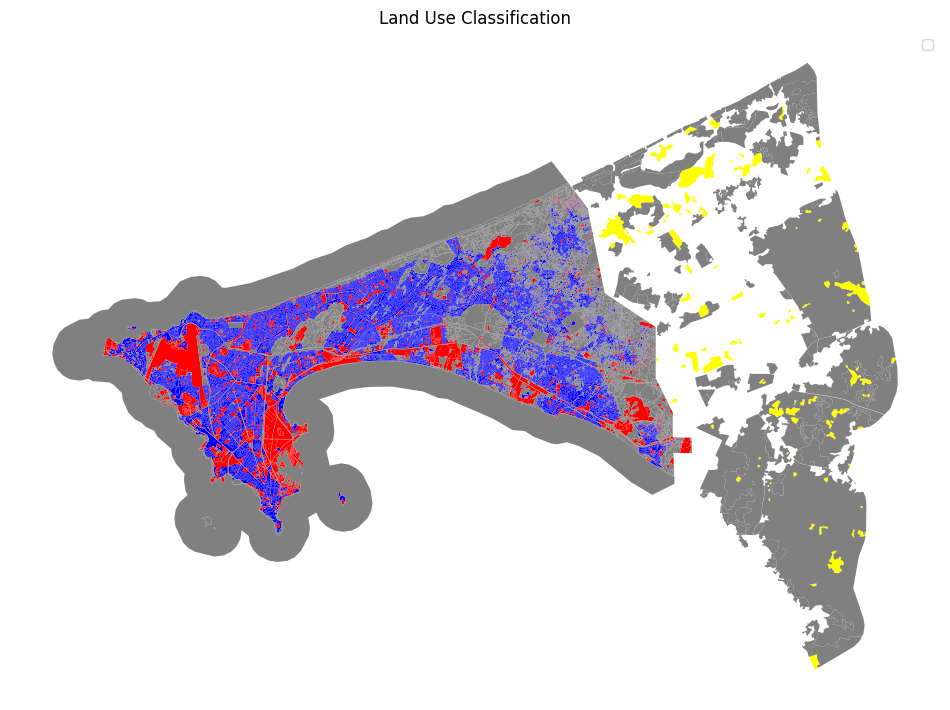

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the classified file
gdf = gpd.read_file("../generated/dakar_landuse_combined.gpkg")

# Set color map for LandUseClass
color_map = {
    'Residential': 'blue',
    'Commercial': 'red',
    'Unclassified Artificial Surfaces': 'yellow',
    'Other': 'gray'
}

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
for land_class, color in color_map.items():
    gdf[gdf["LandUseClass"] == land_class].plot(ax=ax, color=color, label=land_class)

plt.legend()
plt.title("Land Use Classification")
plt.axis('off')
plt.show()

In [ ]:
import os
import geopandas as gpd

folder_path = "../generated/buffer_summary_shapefiles/"
for shapefile in os.listdir(folder_path):
  if shapefile.endswith(".shp") & shapefile.startswith("buildings"): # Added this condition to only read .shp files
    shapefile_path = os.path.join(folder_path, shapefile)
    print(f"Processing: {shapefile_path}")
    gdf = gpd.read_file(shapefile_path)
    print(gdf.head())

Processing: buffer_summary_shapefiles/buildings_500m.shp
   height_dif  height_cha  change  index_righ   LandUseCla  \
0    0.101562           0       2       33101  Residential   
1    0.101562           0       2       33252  Residential   
2    0.101562           0       2       33101  Residential   
3    0.101562           0       2       33252  Residential   
4   -0.257812           0       2       33101  Residential   

                                            geometry  
0  POLYGON ((242146.238 1635518.008, 242150.108 1...  
1  POLYGON ((242146.238 1635518.008, 242150.108 1...  
2  POLYGON ((242146.238 1635518.008, 242150.108 1...  
3  POLYGON ((242146.238 1635518.008, 242150.108 1...  
4  POLYGON ((242138.456 1635514.114, 242142.325 1...  
Processing: buffer_summary_shapefiles/buildings_1km.shp
   height_dif  height_cha  change  index_righ  LandUseCla  \
0    0.960938           0       0       40010  Commercial   
1    0.031250           0       0       40010  Commercial   
2

In [ ]:
import os
import geopandas as gpd

folder_path = "../generated/zone_buffer_exports/"
for shapefile in os.listdir(folder_path):
  if shapefile.endswith(".gpkg") & shapefile.startswith("buildings"): # Added this condition to only read .shp files
    shapefile_path = os.path.join(folder_path, shapefile)
    print(f"Processing: {shapefile_path}")
    gdf = gpd.read_file(shapefile_path)
    print(gdf.head())

Processing: zone_buffer_exports/buildings_residential_500m.gpkg
   height_dif  height_cha  change  index_righ   LandUseCla  index_right   ID  \
0    0.101562           0       2       33101  Residential            7  GU5   
1    0.101562           0       2       33252  Residential            7  GU5   
2    0.101562           0       2       33101  Residential            7  GU5   
3    0.101562           0       2       33252  Residential            7  GU5   
4   -0.257812           0       2       33101  Residential            7  GU5   

          Nom  Superficie  Newfield1        Nomca  AreaANSD  pop2002  \
0  GUEDIAWAYE        3.07     1354.0  Sam Notaire       2.8  58864.0   
1  GUEDIAWAYE        3.07     1354.0  Sam Notaire       2.8  58864.0   
2  GUEDIAWAYE        3.07     1354.0  Sam Notaire       2.8  58864.0   
3  GUEDIAWAYE        3.07     1354.0  Sam Notaire       2.8  58864.0   
4  GUEDIAWAYE        3.07     1354.0  Sam Notaire       2.8  58864.0   

    pop2006   pop2010 

In [ ]:
import geopandas as gpd
import pandas as pd

# Load land use with classification
landuse = gpd.read_file("../generated/dakar_landuse_combined.gpkg", layer="landuse")

# Load transport lines
brt = gpd.read_file("../raw/BRT_full_line.gpkg")
ter = gpd.read_file("../raw/ter_full_line/TER_full_line.shp")  # adjust if it's gpkg

# Load building height change polygons
height_gdf = gpd.read_file("../generated/building_height_diff_and_change_polygons/building_height_diff_and_change_polygons.shp")

# Reproject all to UTM zone 28N for Dakar (EPSG:32628)
crs_target = 32628
landuse = landuse.to_crs(epsg=crs_target)
brt = brt.to_crs(epsg=crs_target)
ter = ter.to_crs(epsg=crs_target)
height_gdf = height_gdf.to_crs(epsg=crs_target)

# Merge BRT and TER into one GeoDataFrame
transport = gpd.GeoDataFrame(pd.concat([brt, ter], ignore_index=True), crs=brt.crs)

# Create buffers: 500m, 1km, 2km
buffers = {
    '500m': transport.buffer(500).unary_union,
    '1km': transport.buffer(1000).unary_union,
    '2km': transport.buffer(2000).unary_union,
    '5km': transport.buffer(5000).unary_union,
    '10km': transport.buffer(10000).unary_union
}

# # Spatial join to assign LandUseClass to building polygons (intersect-based)
height_with_landuse = gpd.sjoin(height_gdf, landuse[['geometry', 'LandUseClass']], how='inner', predicate='intersects')

# Keep only residential and commercial
height_with_landuse = height_with_landuse[height_with_landuse['LandUseClass'].isin(['Residential', 'Commercial', 'Unclassified Artificial Surfaces'])]

results = []

for label, buffer_geom in buffers.items():
    # Select only buildings intersecting the buffer
    in_buffer = height_with_landuse[height_with_landuse.intersects(buffer_geom)]
    grouped = in_buffer.groupby('LandUseClass')

    for landuse_class, group in grouped:
        total = len(group)
        if total == 0:
            continue

        pct_growth = (group['change'] == 1).sum() / total * 100
        pct_loss = (group['change'] == -1).sum() / total * 100
        pct_nochange = (group['change'] == 2).sum() / total * 100
        mean_height_change = group['height_dif'].mean()

        results.append({
            'buffer': label,
            'LandUseClass': landuse_class,
            'mean_height_dif': mean_height_change,
            '%_growth': pct_growth,
            '%_loss': pct_loss,
            '%_no_change': pct_nochange,
            'n_polygons': total
        })

# Final result as DataFrame
final_result = pd.DataFrame(results)
print(final_result)

KeyboardInterrupt: 

In [ ]:
ls

sample_data/


In [ ]:
import geopandas as gpd
import pandas as pd
import os
from shapely.geometry import Polygon

# Load datasets
landuse = gpd.read_file("../generated/dakar_landuse_combined.gpkg", layer="landuse")
brt = gpd.read_file("../raw/BRT_full_line.gpkg")
ter = gpd.read_file("../raw/ter_full_line/TER_full_line.shp")
height_gdf = gpd.read_file("../generated/building_height_2016_polygons/building_height_2016_polygons.shp")

# Reproject to UTM Zone 28N (EPSG:32628)
crs_target = 32628
landuse = landuse.to_crs(epsg=crs_target)
brt = brt.to_crs(epsg=crs_target)
ter = ter.to_crs(epsg=crs_target)
height_gdf = height_gdf.to_crs(epsg=crs_target)

# Combine BRT and TER
transport = gpd.GeoDataFrame(pd.concat([brt, ter], ignore_index=True), crs=crs_target)

# Define buffers (as geometries)
buffer_2km = transport.buffer(2000).unary_union
buffer_5km = transport.buffer(5000).unary_union
buffer_10km = transport.buffer(10000).unary_union

# Donuts by difference
donut_2_5km = buffer_5km.difference(buffer_2km)
donut_5_10km = buffer_10km.difference(buffer_5km)

# Combine all buffer zones
buffers = {
    '500m': transport.buffer(500).unary_union,
    '1km': transport.buffer(1000).unary_union,
    '0_2km': buffer_2km,
    '2_5km': donut_2_5km,
    '5_10km': donut_5_10km
}

# Spatial join to assign land use classes to building polygons
height_with_landuse = gpd.sjoin(
    height_gdf,
    landuse[['geometry', 'LandUseClass']],
    how='inner',
    predicate='intersects'
)

# Filter relevant classes
relevant_classes = ['Residential', 'Commercial', 'Unclassified Artificial Surfaces']
height_with_landuse = height_with_landuse[height_with_landuse['LandUseClass'].isin(relevant_classes)]

# Ensure output directory exists
output_dir = "../generated/buffer_pre_shapefiles"
os.makedirs(output_dir, exist_ok=True)

# Process buffers and export shapefiles
for label, buffer_geom in buffers.items():
    # Select buildings intersecting this buffer zone
    in_buffer = height_with_landuse[height_with_landuse.intersects(buffer_geom)]

    # ---- Export full per-building shapefile ----
    buildings_shp_path = os.path.join(output_dir, f"buildings_{label}.shp")
    in_buffer.to_file(buildings_shp_path)


print(f"✅ Exported donut & regular buffer shapefiles with 'change' class breakdown to: {output_dir}/")

/tmp/ipython-input-6-107355458.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_2km = transport.buffer(2000).unary_union
/tmp/ipython-input-6-107355458.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_5km = transport.buffer(5000).unary_union
/tmp/ipython-input-6-107355458.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_10km = transport.buffer(10000).unary_union
/tmp/ipython-input-6-107355458.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  '500m': transport.buffer(500).unary_union,
/tmp/ipython-input-6-107355458.py:34: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  '1km': transport.buffer(1000).unary_union,
/tmp/ipython-input-6-107355458.py:63: UserWarning: Column names

In [ ]:
import geopandas as gpd
import pandas as pd
import os
from shapely.geometry import Polygon

# Load datasets
landuse = gpd.read_file("../generated/dakar_landuse_combined.gpkg", layer="landuse")
brt = gpd.read_file("../raw/BRT_full_line.gpkg")
ter = gpd.read_file("../raw/ter_full_line/TER_full_line.shp")
pres_gdf = gpd.read_file("../generated/building_presence_change_polygons/diff_presence_polygons.shp")

# Reproject to UTM Zone 28N (EPSG:32628)
crs_target = 32628
landuse = landuse.to_crs(epsg=crs_target)
brt = brt.to_crs(epsg=crs_target)
ter = ter.to_crs(epsg=crs_target)
pres_gdf = pres_gdf.to_crs(epsg=crs_target)

# Combine BRT and TER
transport = gpd.GeoDataFrame(pd.concat([brt, ter], ignore_index=True), crs=crs_target)

# Define buffers (as geometries)
buffer_2km = transport.buffer(2000).unary_union
buffer_5km = transport.buffer(5000).unary_union
buffer_10km = transport.buffer(10000).unary_union

# Donuts by difference
donut_2_5km = buffer_5km.difference(buffer_2km)
donut_5_10km = buffer_10km.difference(buffer_5km)

# Combine all buffer zones
buffers = {
    '500m': transport.buffer(500).unary_union,
    '1km': transport.buffer(1000).unary_union,
    '0_2km': buffer_2km,
    '2_5km': donut_2_5km,
    '5_10km': donut_5_10km
}

# Spatial join to assign land use classes to building polygons
pres_with_landuse = gpd.sjoin(
    pres_gdf,
    landuse[['geometry', 'LandUseClass']],
    how='inner',
    predicate='intersects'
)

# Filter relevant classes
relevant_classes = ['Residential', 'Commercial', 'Unclassified Artificial Surfaces']
pres_with_landuse = pres_with_landuse[pres_with_landuse['LandUseClass'].isin(relevant_classes)]

# Ensure output directory exists
output_dir = "../generated/buffer_presence_change_shapefiles"
os.makedirs(output_dir, exist_ok=True)

# Process buffers and export shapefiles
for label, buffer_geom in buffers.items():
    # Select buildings intersecting this buffer zone
    in_buffer = pres_with_landuse[pres_with_landuse.intersects(buffer_geom)]

    # ---- Export full per-building shapefile ----
    buildings_shp_path = os.path.join(output_dir, f"buildings_{label}.shp")
    in_buffer.to_file(buildings_shp_path)


print(f"✅ Exported donut & regular buffer shapefiles with 'change' class breakdown to: {output_dir}/")

/tmp/ipython-input-12-2047855119.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_2km = transport.buffer(2000).unary_union
/tmp/ipython-input-12-2047855119.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_5km = transport.buffer(5000).unary_union
/tmp/ipython-input-12-2047855119.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_10km = transport.buffer(10000).unary_union
/tmp/ipython-input-12-2047855119.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  '500m': transport.buffer(500).unary_union,
/tmp/ipython-input-12-2047855119.py:34: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  '1km': transport.buffer(1000).unary_union,
/tmp/ipython-input-12-2047855119.py:63: UserWarning: 

✅ Exported donut & regular buffer shapefiles with 'change' class breakdown to: buffer_presence_change_shapefiles/


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'LandUseClass' to 'LandUseCla'
  ogr_write(


    ID         Nom  Superficie  Newfield1              Nomca  AreaANSD  \
0  RU1    RUFISQUE       10.34    37184.0     Rufisque Ouest       9.9   
1  TH1    THIAROYE       17.57     7772.0               Mbao      17.4   
2  GU1  GUEDIAWAYE        4.65     1354.0           Golf Sud       4.1   
3  NI2      NIAYES       10.28     7772.0             Malika       9.0   
4  GU2  GUEDIAWAYE        3.87     1354.0  Wakhinane Nimzatt       3.6   

   pop2002   pop2006   pop2010   pop2025 Nzone  NZonSeq  \
0  33274.0   46382.0   64822.0   79843.0   410     76.0   
1  26011.0   22193.0   32683.0   52109.0   390     74.0   
2  71889.0  114210.0  129183.0  196687.0   190     53.0   
3  14167.0   12270.0   10761.0   16522.0   360     70.0   
4  62767.0   96109.0  108709.0  165515.0   340     68.0   

                                            geometry  
0  POLYGON ((254783.95 1630359.49, 254599.61 1630...  
1  POLYGON ((250398.38 1634242.15, 251381.48 1633...  
2  POLYGON ((241378 1634318.72, 241

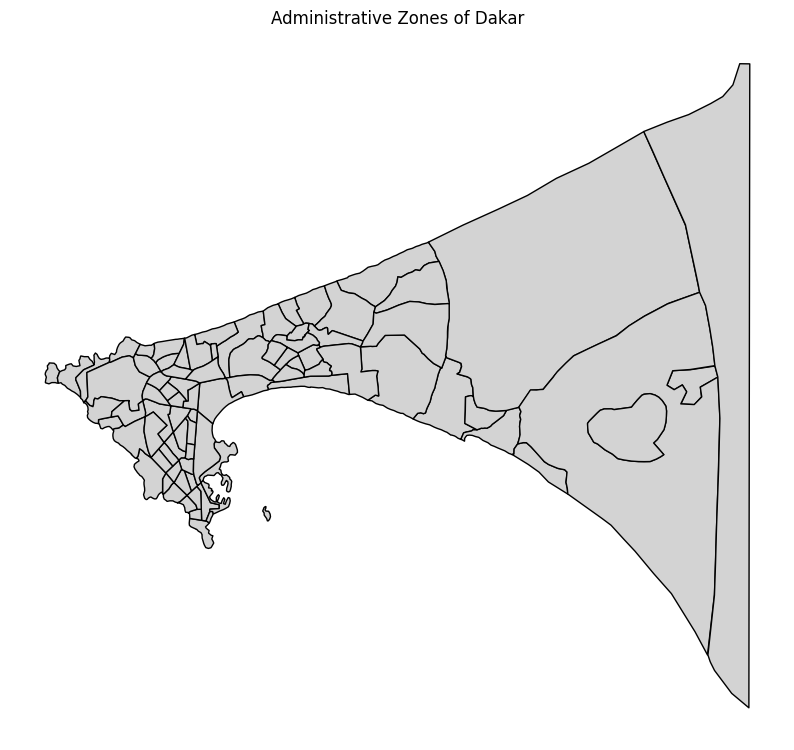

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Dakar zones shapefile
zones = gpd.read_file("../raw/Dakar_zones")

# Check the first few rows
print(zones.head())

# Check the CRS
print(zones.crs)

fig, ax = plt.subplots(figsize=(10, 10))
zones.plot(ax=ax, edgecolor='black', facecolor='lightgrey')

# Optional: add zone names/IDs as labels
if 'zone_name' in zones.columns:  # Replace with actual name column
    zones.apply(lambda x: ax.annotate(text=x['zone_name'], xy=x.geometry.centroid.coords[0],
                                       ha='center', fontsize=8), axis=1)

plt.title("Administrative Zones of Dakar")
plt.axis('off')
plt.show()

In [ ]:
import os
import geopandas as gpd
import pandas as pd

# Load Dakar zones
zones = gpd.read_file("../raw/Dakar_zones")
zones = zones.to_crs(epsg=32628)

# Define buffers and building shapefile folder
buffer_dir = "../generated/buffer_presence_change_shapefiles"
buffer_labels = ['500m', '1km', '0_2km', '2_5km', '5_10km']

# Load buildings
buffer_buildings = {}
for label in buffer_labels:
    path = os.path.join(buffer_dir, f"buildings_{label}.shp")
    print(f"📂 Reading: {path}")
    gdf = gpd.read_file(path)
    gdf = gdf.to_crs(epsg=32628)
    print(f"✅ Loaded {label} buffer. Columns: {list(gdf.columns)}")
    buffer_buildings[label] = gdf

# Prep
zone_stats = []
export_dir = "../generated/zone_buffer_presence_change"
os.makedirs(export_dir, exist_ok=True)

for label, gdf in buffer_buildings.items():
    print(f"\n🔍 Processing buffer: {label}")

    # Spatial join with zones
    gdf_zone = gpd.sjoin(gdf, zones, how='inner', predicate='intersects')
    print(f"👉 After spatial join: {len(gdf_zone)} records")
    print("📌 Columns after join:", gdf_zone.columns.tolist())
    print("📌 Sample rows:\n", gdf_zone.head())

    # Debug: check if 'LandUseClass' is present
    if 'LandUseCla' not in gdf_zone.columns:
        print("❌ 'LandUseClass' column missing in spatial join output!")
        print("✅ Available columns:", gdf_zone.columns.tolist())
        raise KeyError("'LandUseClass' is missing. Please check your building shapefile attributes.")

    # Group by zone and land use class
    zone_summary = (
        gdf_zone
        .groupby(['Nom', 'LandUseCla'])['diff_prese']
        .agg(['mean', 'count'])
        .reset_index()
    )
    print(f"📊 Aggregated zone summary for {label}:\n", zone_summary.head())

    zone_summary['buffer'] = label
    zone_stats.append(zone_summary)

    # Export per-building files by land use
    for lu in gdf_zone['LandUseCla'].dropna().unique():
        sub_buildings = gdf_zone[gdf_zone['LandUseCla'] == lu].copy()
        lu_clean = lu.lower().replace(' ', '_').replace('/', '_')
        filepath = os.path.join(export_dir, f"buildings_{lu_clean}_{label}.gpkg")
        print(f"💾 Exporting per-building layer: {filepath}")
        sub_buildings.to_file(filepath, layer='data', driver='GPKG')

# Combine zone summaries
df_zone_stats = pd.concat(zone_stats, ignore_index=True)
df_zone_stats.rename(columns={'Nom': 'zone_name'}, inplace=True)

# Export aggregated zone stats
for label in df_zone_stats['buffer'].unique():
    for lu in df_zone_stats['LandUseCla'].dropna().unique():
        sub = df_zone_stats[(df_zone_stats['buffer'] == label) &
                            (df_zone_stats['LandUseCla'] == lu)]

        zones_with_data = zones.merge(sub, left_on='Nom', right_on='zone_name')
        if not zones_with_data.empty:
            lu_clean = lu.lower().replace(' ', '_').replace('/', '_')
            filepath = os.path.join(export_dir, f"zones_{lu_clean}_{label}.gpkg")
            print(f"💾 Exporting zone-level GPKG: {filepath}")
            zones_with_data.to_file(filepath, layer='data', driver='GPKG')

print("✅ All exports completed.")

📂 Reading: buffer_presence_change_shapefiles/buildings_500m.shp
✅ Loaded 500m buffer. Columns: ['pres_2016', 'pres_2023', 'diff_prese', 'index_righ', 'LandUseCla', 'geometry']
📂 Reading: buffer_presence_change_shapefiles/buildings_1km.shp
✅ Loaded 1km buffer. Columns: ['pres_2016', 'pres_2023', 'diff_prese', 'index_righ', 'LandUseCla', 'geometry']
📂 Reading: buffer_presence_change_shapefiles/buildings_0_2km.shp
✅ Loaded 0_2km buffer. Columns: ['pres_2016', 'pres_2023', 'diff_prese', 'index_righ', 'LandUseCla', 'geometry']
📂 Reading: buffer_presence_change_shapefiles/buildings_2_5km.shp
✅ Loaded 2_5km buffer. Columns: ['pres_2016', 'pres_2023', 'diff_prese', 'index_righ', 'LandUseCla', 'geometry']
📂 Reading: buffer_presence_change_shapefiles/buildings_5_10km.shp
✅ Loaded 5_10km buffer. Columns: ['pres_2016', 'pres_2023', 'diff_prese', 'index_righ', 'LandUseCla', 'geometry']

🔍 Processing buffer: 500m
👉 After spatial join: 2221922 records
📌 Columns after join: ['pres_2016', 'pres_2023', 

                         LandUseCla  mean_diff  n_bldgs buffer  \
0                        Commercial   0.581695   467324   500m   
1                       Residential   0.553045  1707441   500m   
2  Unclassified Artificial Surfaces   2.993455      684   500m   

                                            geometry  
0  POLYGON ((236421.592 1624120.801, 236419.719 1...  
1  POLYGON ((236421.592 1624120.801, 236419.719 1...  
2  POLYGON ((236421.592 1624120.801, 236419.719 1...  
                         LandUseCla  mean_diff  n_bldgs buffer  \
0                        Commercial   0.587684   755726    1km   
1                       Residential   0.594937  3176359    1km   
2  Unclassified Artificial Surfaces   2.821009      718    1km   

                                            geometry  
0  POLYGON ((236006.461 1623842.114, 236002.716 1...  
1  POLYGON ((236006.461 1623842.114, 236002.716 1...  
2  POLYGON ((236006.461 1623842.114, 236002.716 1...  
                         LandU

<Axes: >

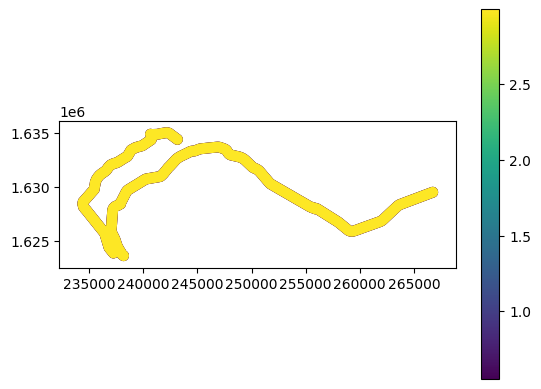

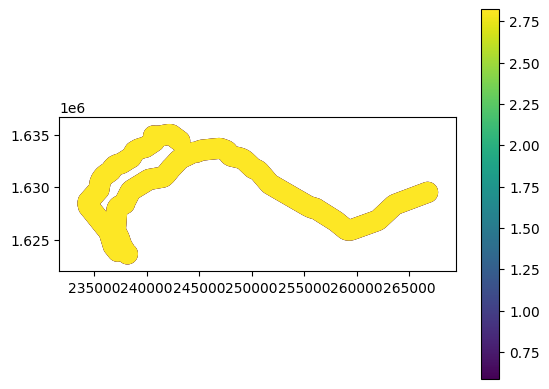

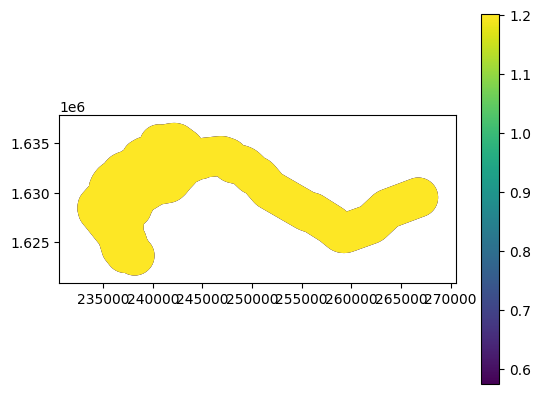

In [ ]:
import geopandas as gpd

summary_500 = gpd.read_file("../generated/buffer_summary_shapefiles/summary_500m.shp")
summary_1km = gpd.read_file("../generated/buffer_summary_shapefiles/summary_1km.shp")
summary_2km = gpd.read_file("../generated/buffer_summary_shapefiles/summary_2km.shp")
print(summary_500)
print(summary_1km)
print(summary_2km)

# View overall stats
print(summary_500.describe())
print(summary_1km.describe())
print(summary_2km.describe())

# Plot if desired
summary_500.plot(column='mean_diff', legend=True)
summary_1km.plot(column='mean_diff', legend=True)
summary_2km.plot(column='mean_diff', legend=True)

In [7]:
import geopandas as gpd
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
import pickle
import warnings

warnings.filterwarnings("ignore")

# === 1. Load difference files only ===
treated_diff = gpd.read_file("../generated/zone_buffer_presence_change/buildings_commercial_0_2km.gpkg")
control_diff = gpd.read_file("../generated/zone_buffer_presence_change/buildings_commercial_5_10km.gpkg")

# === 2. Add group and calculate post-period presence ===
treated = treated_diff.copy()
treated["group"] = "treated"
treated["pres_2023"] = treated["pres_2016"] + treated["diff_prese"]

control = control_diff.copy()
control["group"] = "control"
control["pres_2023"] = control["pres_2016"] + control["diff_prese"]

# Concatenate and prepare panel format
cols = ["pres_2016", "diff_prese", "pres_2023", "group", "LandUseCla"]
df = pd.concat([treated[cols], control[cols]])
df["pres"] = df["pres_2016"]  # initial
df["post_pres"] = df["pres_2023"]  # future

# === 3. Stack for DiD ===
df_long = pd.concat([
    df.assign(period=0, presence=df["pres_2016"]),
    df.assign(period=1, presence=df["pres_2023"])
], ignore_index=True)

df_long["post"] = df_long["period"]
df_long["treated"] = (df_long["group"] == "treated").astype(int)
df_long["post_treated"] = df_long["post"] * df_long["treated"]

# === 4. Run OLS DiD per land use class ===
land_use_classes = df_long["LandUseCla"].dropna().unique()
ols_results = []

for lu in land_use_classes:
    print(f"\n=== Land Use Class: {lu} ===")
    df_lu = df_long[df_long["LandUseCla"] == lu]

    print("\n[OLS] Difference-in-Differences on presence:")
    try:
        model = smf.ols("presence ~ post + treated + post_treated", data=df_lu)
        result = model.fit()
        print(result.summary())

        ols_results.append({
            "LandUseCla": lu,
            "coef_post": result.params.get("post", None),
            "coef_treated": result.params.get("treated", None),
            "coef_post_treated": result.params.get("post_treated", None),
            "pval_post_treated": result.pvalues.get("post_treated", None),
            "r_squared": result.rsquared
        })
    except Exception as e:
        print(f"OLS failed for {lu}: {e}")

# === 5. Export OLS results ===
pd.DataFrame(ols_results).to_csv("../output/5_10control/zone_buffer_presence_change/ols_did_presence_commercial_5_10results.csv", index=False)
print("\n✅ Exported OLS DiD results for presence change.")


=== Land Use Class: Commercial ===

[OLS] Difference-in-Differences on presence:
                            OLS Regression Results                            
Dep. Variable:               presence   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2067.
Date:                Fri, 20 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:55:23   Log-Likelihood:            -7.0975e+05
No. Observations:             2467920   AIC:                         1.420e+06
Df Residuals:                 2467916   BIC:                         1.420e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [8]:

# === 1. Load difference files only ===
treated_diff = gpd.read_file("../generated/zone_buffer_presence_change/buildings_residential_0_2km.gpkg")
control_diff = gpd.read_file("../generated/zone_buffer_presence_change/buildings_residential_5_10km.gpkg")

# === 2. Add group and calculate post-period presence ===
treated = treated_diff.copy()
treated["group"] = "treated"
treated["pres_2023"] = treated["pres_2016"] + treated["diff_prese"]

control = control_diff.copy()
control["group"] = "control"
control["pres_2023"] = control["pres_2016"] + control["diff_prese"]

# Concatenate and prepare panel format
cols = ["pres_2016", "diff_prese", "pres_2023", "group", "LandUseCla"]
df = pd.concat([treated[cols], control[cols]])
df["pres"] = df["pres_2016"]  # initial
df["post_pres"] = df["pres_2023"]  # future

# === 3. Stack for DiD ===
df_long = pd.concat([
    df.assign(period=0, presence=df["pres_2016"]),
    df.assign(period=1, presence=df["pres_2023"])
], ignore_index=True)

df_long["post"] = df_long["period"]
df_long["treated"] = (df_long["group"] == "treated").astype(int)
df_long["post_treated"] = df_long["post"] * df_long["treated"]

# === 4. Run OLS DiD per land use class ===
land_use_classes = df_long["LandUseCla"].dropna().unique()
ols_results = []

for lu in land_use_classes:
    print(f"\n=== Land Use Class: {lu} ===")
    df_lu = df_long[df_long["LandUseCla"] == lu]

    print("\n[OLS] Difference-in-Differences on presence:")
    try:
        model = smf.ols("presence ~ post + treated + post_treated", data=df_lu)
        result = model.fit()
        print(result.summary())

        ols_results.append({
            "LandUseCla": lu,
            "coef_post": result.params.get("post", None),
            "coef_treated": result.params.get("treated", None),
            "coef_post_treated": result.params.get("post_treated", None),
            "pval_post_treated": result.pvalues.get("post_treated", None),
            "r_squared": result.rsquared
        })
    except Exception as e:
        print(f"OLS failed for {lu}: {e}")

# === 5. Export OLS results ===
pd.DataFrame(ols_results).to_csv("../output/5_10control/ols_did_presence_residential_5_10kmresults.csv", index=False)
print("\n✅ Exported OLS DiD results for presence change.")


=== Land Use Class: Residential ===

[OLS] Difference-in-Differences on presence:
                            OLS Regression Results                            
Dep. Variable:               presence   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                 5.345e+04
Date:                Fri, 20 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:04:46   Log-Likelihood:            -1.4963e+06
No. Observations:            10687316   AIC:                         2.993e+06
Df Residuals:                10687312   BIC:                         2.993e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [9]:

# === 1. Load difference files only ===
treated_diff = gpd.read_file("../generated/zone_buffer_presence_change/buildings_unclassified_artificial_surfaces_0_2km.gpkg")
control_diff = gpd.read_file("../generated/zone_buffer_presence_change/buildings_unclassified_artificial_surfaces_5_10km.gpkg")

# === 2. Add group and calculate post-period presence ===
treated = treated_diff.copy()
treated["group"] = "treated"
treated["pres_2023"] = treated["pres_2016"] + treated["diff_prese"]

control = control_diff.copy()
control["group"] = "control"
control["pres_2023"] = control["pres_2016"] + control["diff_prese"]

# Concatenate and prepare panel format
cols = ["pres_2016", "diff_prese", "pres_2023", "group", "LandUseCla"]
df = pd.concat([treated[cols], control[cols]])
df["pres"] = df["pres_2016"]  # initial
df["post_pres"] = df["pres_2023"]  # future

# === 3. Stack for DiD ===
df_long = pd.concat([
    df.assign(period=0, presence=df["pres_2016"]),
    df.assign(period=1, presence=df["pres_2023"])
], ignore_index=True)

df_long["post"] = df_long["period"]
df_long["treated"] = (df_long["group"] == "treated").astype(int)
df_long["post_treated"] = df_long["post"] * df_long["treated"]

# === 4. Run OLS DiD per land use class ===
land_use_classes = df_long["LandUseCla"].dropna().unique()
ols_results = []

for lu in land_use_classes:
    print(f"\n=== Land Use Class: {lu} ===")
    df_lu = df_long[df_long["LandUseCla"] == lu]

    print("\n[OLS] Difference-in-Differences on presence:")
    try:
        model = smf.ols("presence ~ post + treated + post_treated", data=df_lu)
        result = model.fit()
        print(result.summary())

        ols_results.append({
            "LandUseCla": lu,
            "coef_post": result.params.get("post", None),
            "coef_treated": result.params.get("treated", None),
            "coef_post_treated": result.params.get("post_treated", None),
            "pval_post_treated": result.pvalues.get("post_treated", None),
            "r_squared": result.rsquared
        })
    except Exception as e:
        print(f"OLS failed for {lu}: {e}")

# === 5. Export OLS results ===
pd.DataFrame(ols_results).to_csv("../output/5_10control/ols_did_presence_uas_5_10results.csv", index=False)
print("\n✅ Exported OLS DiD results for presence change.")


=== Land Use Class: Unclassified Artificial Surfaces ===

[OLS] Difference-in-Differences on presence:
                            OLS Regression Results                            
Dep. Variable:               presence   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     758.5
Date:                Fri, 20 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:05:20   Log-Likelihood:                -10219.
No. Observations:              159596   AIC:                         2.045e+04
Df Residuals:                  159592   BIC:                         2.049e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [ ]:
import geopandas as gpd
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import warnings

warnings.filterwarnings("ignore")

# === 1. Load data ===
treated_2016 = gpd.read_file("../generated/zone_buffer_exports_16/buildings_commercial_0_2km.gpkg")
control_2016 = gpd.read_file("../generated/zone_buffer_exports_16/buildings_commercial_2_5km.gpkg")
treated_diff = gpd.read_file("../generated/zone_buffer_exports/buildings_commercial_0_2km.gpkg")
control_diff = gpd.read_file("../generated/zone_buffer_exports/buildings_commercial_2_5km.gpkg")

# === 2. Merge 2016 and diff files ===
treated = treated_2016.copy()
for col in ["height_dif", "change", "height_cha"]:
    treated[col] = treated_diff[col]
treated["group"] = "treated"

control = control_2016.copy()
for col in ["height_dif", "change", "height_cha"]:
    control[col] = control_diff[col]
control["group"] = "control"

# Concatenate and compute post height
cols = ["height_201", "height_dif", "height_cha", "change", "group", "LandUseCla"]
df = pd.concat([treated[cols], control[cols]])
df["height_post"] = df["height_201"] + df["height_dif"]

# === 3. Create stacked long-format for OLS DiD ===
df_long = pd.concat([
    df.assign(period=0, height=df["height_201"]),
    df.assign(period=1, height=df["height_post"])
], ignore_index=True)

df_long["post"] = df_long["period"]
df_long["treated"] = (df_long["group"] == "treated").astype(int)
df_long["post_treated"] = df_long["post"] * df_long["treated"]

# === 4. Loop through LandUseCla and run DiD ===
land_use_classes = df_long["LandUseCla"].dropna().unique()

ols_results = []
logit_change_results = []
logit_heightcha_results = []

for lu in land_use_classes:
    print(f"\n=== Land Use Class: {lu} ===")
    df_lu = df_long[df_long["LandUseCla"] == lu]

    # --- (a) OLS DiD for height ---
    print("\n[OLS] Difference-in-Differences on height:")
    try:
        model = smf.ols("height ~ post + treated + post_treated", data=df_lu)
        result = model.fit()
        print(result.summary())

        ols_results.append({
            "LandUseCla": lu,
            "coef_post": result.params.get("post", None),
            "coef_treated": result.params.get("treated", None),
            "coef_post_treated": result.params.get("post_treated", None),
            "pval_post_treated": result.pvalues.get("post_treated", None),
            "r_squared": result.rsquared
        })
    except Exception as e:
        print(f"OLS failed for {lu}: {e}")

    # --- (b) Multinomial Logit for 'change' ---
    print("\n[Multinomial Logit] DiD on categorical 'change':")
    try:
        df_change = df_lu[df_lu["post"] == 1].dropna(subset=["change"]).copy()
        df_change["change"] = df_change["change"].astype(int)
        X = df_change[["post", "treated", "post_treated"]].values
        y = df_change["change"].values

        clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
        clf.fit(X, y)

        print("Class labels:", clf.classes_)
        print("Coefficients (per class):\n", clf.coef_)
        print("Intercepts:\n", clf.intercept_)

        logit_change_results.append({
            "LandUseCla": lu,
            "classes": clf.classes_,
            "coef": clf.coef_,
            "intercept": clf.intercept_
        })
    except Exception as e:
        print(f"Multinomial Logit failed for 'change' in {lu}: {e}")

    # --- (c) Multinomial Logit for 'height_cha' ---
    print("\n[Multinomial Logit] DiD on categorical 'height_cha':")
    try:
        df_cha = df_lu[df_lu["post"] == 1].dropna(subset=["height_cha"]).copy()
        df_cha["height_cha"] = df_cha["height_cha"].astype(int)
        X = df_cha[["post", "treated", "post_treated"]].values
        y = df_cha["height_cha"].values

        clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
        clf.fit(X, y)

        print("Class labels:", clf.classes_)
        print("Coefficients (per class):\n", clf.coef_)
        print("Intercepts:\n", clf.intercept_)

        logit_heightcha_results.append({
            "LandUseCla": lu,
            "classes": clf.classes_,
            "coef": clf.coef_,
            "intercept": clf.intercept_
        })
    except Exception as e:
        print(f"Multinomial Logit failed for 'height_cha' in {lu}: {e}")

# === 5. Export Results ===
pd.DataFrame(ols_results).to_csv("../output/2_5control/ols_did_commercial_results.csv", index=False)

# with open("logit_change_commercial_results.pkl", "wb") as f:
#     pickle.dump(logit_change_results, f)

# with open("logit_heightcha_commercial_results.pkl", "wb") as f:
#     pickle.dump(logit_heightcha_results, f)




=== Land Use Class: Commercial ===

[OLS] Difference-in-Differences on height:
                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3808.
Date:                Tue, 17 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:39:42   Log-Likelihood:            -6.2077e+06
No. Observations:             2070856   AIC:                         1.242e+07
Df Residuals:                 2070852   BIC:                         1.242e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

In [ ]:
import geopandas as gpd
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import warnings

warnings.filterwarnings("ignore")

# === 1. Load data ===
treated_2016 = gpd.read_file("../zone_buffer_exports_16/buildings_residential_0_2km.gpkg")
control_2016 = gpd.read_file("../zone_buffer_exports_16/buildings_residential_2_5km.gpkg")
treated_diff = gpd.read_file("../generated/zone_buffer_exports/buildings_residential_0_2km.gpkg")
control_diff = gpd.read_file("../generated/zone_buffer_exports/buildings_residential_2_5km.gpkg")

# === 2. Merge 2016 and diff files ===
treated = treated_2016.copy()
for col in ["height_dif", "change", "height_cha"]:
    treated[col] = treated_diff[col]
treated["group"] = "treated"

control = control_2016.copy()
for col in ["height_dif", "change", "height_cha"]:
    control[col] = control_diff[col]
control["group"] = "control"

# Concatenate and compute post height
cols = ["height_201", "height_dif", "height_cha", "change", "group", "LandUseCla"]
df = pd.concat([treated[cols], control[cols]])
df["height_post"] = df["height_201"] + df["height_dif"]

# === 3. Create stacked long-format for OLS DiD ===
df_long = pd.concat([
    df.assign(period=0, height=df["height_201"]),
    df.assign(period=1, height=df["height_post"])
], ignore_index=True)

df_long["post"] = df_long["period"]
df_long["treated"] = (df_long["group"] == "treated").astype(int)
df_long["post_treated"] = df_long["post"] * df_long["treated"]

# === 4. Loop through LandUseCla and run DiD ===
land_use_classes = df_long["LandUseCla"].dropna().unique()

ols_results = []
logit_change_results = []
logit_heightcha_results = []

for lu in land_use_classes:
    print(f"\n=== Land Use Class: {lu} ===")
    df_lu = df_long[df_long["LandUseCla"] == lu]

    # --- (a) OLS DiD for height ---
    print("\n[OLS] Difference-in-Differences on height:")
    try:
        model = smf.ols("height ~ post + treated + post_treated", data=df_lu)
        result = model.fit()
        print(result.summary())

        ols_results.append({
            "LandUseCla": lu,
            "coef_post": result.params.get("post", None),
            "coef_treated": result.params.get("treated", None),
            "coef_post_treated": result.params.get("post_treated", None),
            "pval_post_treated": result.pvalues.get("post_treated", None),
            "r_squared": result.rsquared
        })
    except Exception as e:
        print(f"OLS failed for {lu}: {e}")

    # --- (b) Multinomial Logit for 'change' ---
    print("\n[Multinomial Logit] DiD on categorical 'change':")
    try:
        df_change = df_lu[df_lu["post"] == 1].dropna(subset=["change"]).copy()
        df_change["change"] = df_change["change"].astype(int)
        X = df_change[["post", "treated", "post_treated"]].values
        y = df_change["change"].values

        clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
        clf.fit(X, y)

        print("Class labels:", clf.classes_)
        print("Coefficients (per class):\n", clf.coef_)
        print("Intercepts:\n", clf.intercept_)

        logit_change_results.append({
            "LandUseCla": lu,
            "classes": clf.classes_,
            "coef": clf.coef_,
            "intercept": clf.intercept_
        })
    except Exception as e:
        print(f"Multinomial Logit failed for 'change' in {lu}: {e}")

    # --- (c) Multinomial Logit for 'height_cha' ---
    print("\n[Multinomial Logit] DiD on categorical 'height_cha':")
    try:
        df_cha = df_lu[df_lu["post"] == 1].dropna(subset=["height_cha"]).copy()
        df_cha["height_cha"] = df_cha["height_cha"].astype(int)
        X = df_cha[["post", "treated", "post_treated"]].values
        y = df_cha["height_cha"].values

        clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
        clf.fit(X, y)

        print("Class labels:", clf.classes_)
        print("Coefficients (per class):\n", clf.coef_)
        print("Intercepts:\n", clf.intercept_)

        logit_heightcha_results.append({
            "LandUseCla": lu,
            "classes": clf.classes_,
            "coef": clf.coef_,
            "intercept": clf.intercept_
        })
    except Exception as e:
        print(f"Multinomial Logit failed for 'height_cha' in {lu}: {e}")

# === 5. Export Results ===
pd.DataFrame(ols_results).to_csv("../output/2_5control/ols_did_residential_results.csv", index=False)

# with open("logit_change_residential_results.pkl", "wb") as f:
#     pickle.dump(logit_change_results, f)

# with open("logit_heightcha_residential_results.pkl", "wb") as f:
#     pickle.dump(logit_heightcha_results, f)


=== Land Use Class: Residential ===

[OLS] Difference-in-Differences on height:
                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                 6.584e+04
Date:                Tue, 17 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:49:05   Log-Likelihood:            -3.3290e+07
No. Observations:            12017634   AIC:                         6.658e+07
Df Residuals:                12017630   BIC:                         6.658e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------


=== Land Use Class: Unclassified Artificial Surfaces ===
[OLS] Difference-in-Differences on height:
                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     330.6
Date:                Tue, 17 Jun 2025   Prob (F-statistic):          2.41e-213
Time:                        22:54:10   Log-Likelihood:            -2.1741e+05
No. Observations:               78846   AIC:                         4.348e+05
Df Residuals:                   78842   BIC:                         4.349e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

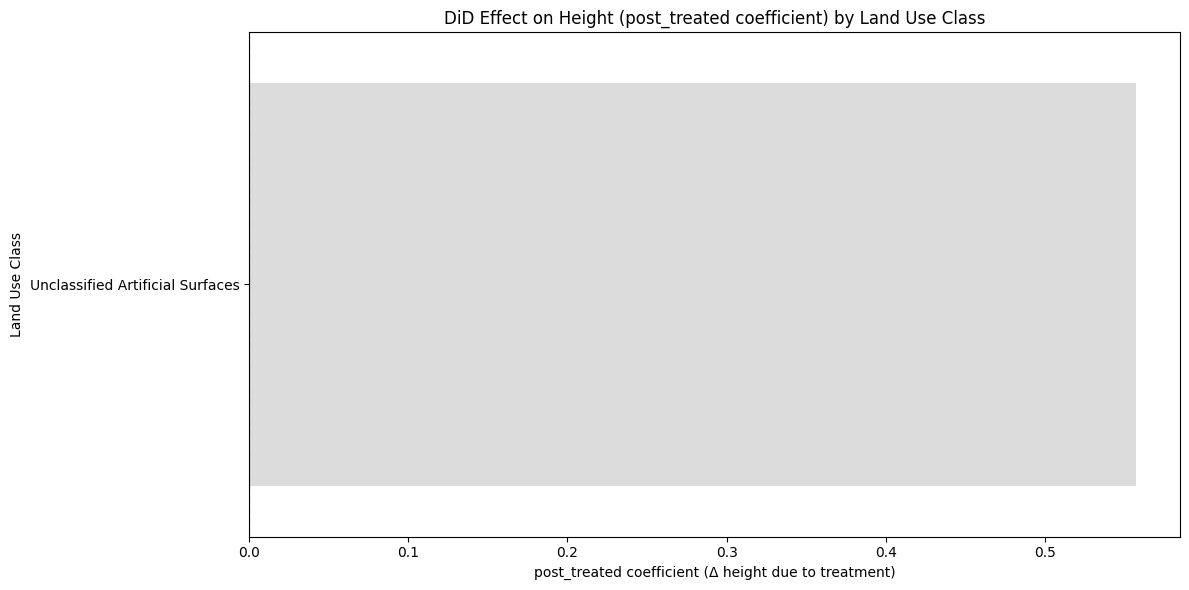

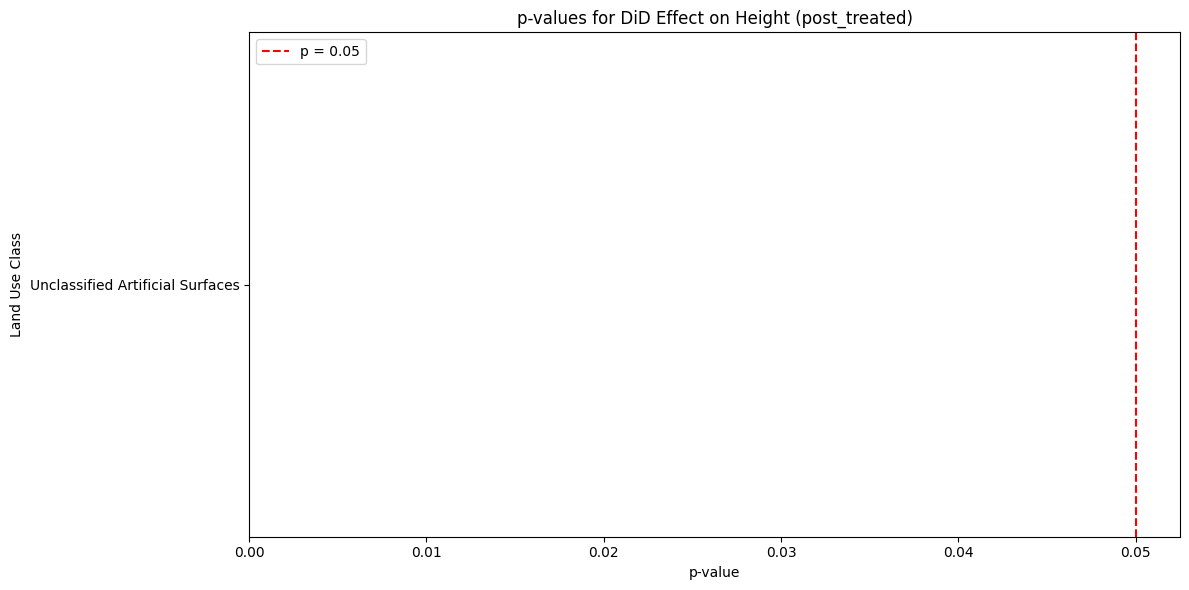

In [ ]:
import geopandas as gpd
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import warnings

warnings.filterwarnings("ignore")

# === 1. Load data ===
treated_2016 = gpd.read_file("../zone_buffer_exports_16/buildings_unclassified_artificial_surfaces_0_2km.gpkg")
control_2016 = gpd.read_file("../zone_buffer_exports_16/buildings_unclassified_artificial_surfaces_2_5km.gpkg")
treated_diff = gpd.read_file("../generated/zone_buffer_exports/buildings_unclassified_artificial_surfaces_0_2km.gpkg")
control_diff = gpd.read_file("../generated/zone_buffer_exports/buildings_unclassified_artificial_surfaces_2_5km.gpkg")

# === 2. Merge 2016 and diff files ===
treated = treated_2016.copy()
for col in ["height_dif", "change", "height_cha"]:
    treated[col] = treated_diff[col]
treated["group"] = "treated"

control = control_2016.copy()
for col in ["height_dif", "change", "height_cha"]:
    control[col] = control_diff[col]
control["group"] = "control"

# === 3. Concatenate and prepare long-format ===
cols = ["height_201", "height_dif", "height_cha", "change", "group", "LandUseCla"]
df = pd.concat([treated[cols], control[cols]])
df["height_post"] = df["height_201"] + df["height_dif"]

df_long = pd.concat([
    df.assign(period=0, height=df["height_201"]),
    df.assign(period=1, height=df["height_post"])
], ignore_index=True)

df_long["post"] = df_long["period"]
df_long["treated"] = (df_long["group"] == "treated").astype(int)
df_long["post_treated"] = df_long["post"] * df_long["treated"]

# === 4. Run DiD models ===
land_use_classes = df_long["LandUseCla"].dropna().unique()

ols_results = []
logit_change_results = []
logit_heightcha_results = []

for lu in land_use_classes:
    print(f"\n=== Land Use Class: {lu} ===")
    df_lu = df_long[df_long["LandUseCla"] == lu]

    # --- (a) OLS DiD on height ---
    print("[OLS] Difference-in-Differences on height:")
    try:
        model = smf.ols("height ~ post + treated + post_treated", data=df_lu)
        result = model.fit()
        print(result.summary())

        ols_results.append({
            "LandUseCla": lu,
            "coef_post": result.params.get("post", None),
            "coef_treated": result.params.get("treated", None),
            "coef_post_treated": result.params.get("post_treated", None),
            "pval_post_treated": result.pvalues.get("post_treated", None),
            "r_squared": result.rsquared
        })
    except Exception as e:
        print(f"OLS failed for {lu}: {e}")

    # --- (b) Multinomial Logit on 'change' ---
    print("[Multinomial Logit] DiD on categorical 'change':")
    try:
        df_change = df_lu[df_lu["post"] == 1].dropna(subset=["change"]).copy()
        df_change["change"] = df_change["change"].astype(int)
        X = df_change[["post", "treated", "post_treated"]].values
        y = df_change["change"].values

        clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
        clf.fit(X, y)

        logit_change_results.append({
            "LandUseCla": lu,
            "classes": clf.classes_,
            "coef": clf.coef_,
            "intercept": clf.intercept_
        })
    except Exception as e:
        print(f"Multinomial Logit failed for 'change' in {lu}: {e}")

    # --- (c) Multinomial Logit on 'height_cha' ---
    print("[Multinomial Logit] DiD on categorical 'height_cha':")
    try:
        df_cha = df_lu[df_lu["post"] == 1].dropna(subset=["height_cha"]).copy()
        df_cha["height_cha"] = df_cha["height_cha"].astype(int)
        X = df_cha[["post", "treated", "post_treated"]].values
        y = df_cha["height_cha"].values

        clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
        clf.fit(X, y)

        logit_heightcha_results.append({
            "LandUseCla": lu,
            "classes": clf.classes_,
            "coef": clf.coef_,
            "intercept": clf.intercept_
        })
    except Exception as e:
        print(f"Multinomial Logit failed for 'height_cha' in {lu}: {e}")

# === 5. Export Results ===
pd.DataFrame(ols_results).to_csv("../output/2_5control/ols_did_unclassified_artifical_surfaces_results.csv", index=False)

# with open("logit_change_unclassified_artifical_surfaces_results.pkl", "wb") as f:
#     pickle.dump(logit_change_results, f)

# with open("logit_heightcha_unclassified_artifical_surfaces_results.pkl", "wb") as f:
    pickle.dump(logit_heightcha_results, f)

# === 6. Plot OLS DiD Coefficients ===
# ols_df = pd.DataFrame(ols_results)
# ols_df = ols_df.dropna(subset=["coef_post_treated"])  # Drop NaNs
# ols_df = ols_df.sort_values("coef_post_treated")

# if not ols_df.empty:
#     plt.figure(figsize=(12, 6))
#     sns.barplot(data=ols_df, x="coef_post_treated", y="LandUseCla", palette="coolwarm")
#     plt.axvline(0, color="black", linestyle="--")
#     plt.title("DiD Effect on Height (post_treated coefficient) by Land Use Class")
#     plt.xlabel("post_treated coefficient (Δ height due to treatment)")
#     plt.ylabel("Land Use Class")
#     plt.tight_layout()
#     plt.savefig("did_unclassified_artifical_surfaces_height_effect_by_landuse.png")
#     plt.show()
# else:
#     print("No valid OLS results to plot.")

# # === 7. Plot p-values ===
# ols_df = ols_df.dropna(subset=["pval_post_treated"])
# if not ols_df.empty:
#     plt.figure(figsize=(12, 6))
#     sns.barplot(data=ols_df, x="pval_post_treated", y="LandUseCla", palette="viridis_r")
#     plt.axvline(0.05, color="red", linestyle="--", label="p = 0.05")
#     plt.title("p-values for DiD Effect on Height (post_treated)")
#     plt.xlabel("p-value")
#     plt.ylabel("Land Use Class")
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig("did_unclassified_artifical_surfaces_height_pvalues_by_landuse.png")
#     plt.show()
# else:
#     print("No p-values available to plot.")

# # === 8. Multinomial heatmaps (change) ===
# for r in logit_change_results:
#     lu = r["LandUseCla"]
#     coef = np.array(r["coef"])
#     classes = r["classes"]
#     labels = ["post", "treated", "post_treated"]

#     if coef.size > 0:
#         plt.figure(figsize=(8, 4))
#         sns.heatmap(coef, annot=True, fmt=".2f", xticklabels=labels, yticklabels=classes, cmap="RdBu", center=0)
#         plt.title(f"Multinomial Coefficients for 'change' in {lu}")
#         plt.tight_layout()
#         plt.savefig(f"logit_unclassified_artifical_surfaces_change_coef_{lu}.png")
#         plt.close()
#     else:
#         print(f"Empty coef matrix for {lu}, skipping plot.")